In [202]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from utils import *
from scipy.fft import fft, fftfreq, fftshift

In [258]:
df = load_amb_sin_data("amb_sin/sine_fy_69Hz_0RPM.txt")

In [259]:
def to_seconds(x):
    try:
        return x.delta*1e-9
    except:
        return np.nan
    
df["dt"] = (df["datetime"] - df["datetime"].shift()).apply(to_seconds)
df["t"]  = df["dt"].cumsum()

In [260]:
df

,datetime,ax,ay,bx,by,f_ax,f_ay,f_bx,f_by,e_ax,e_ay,e_bx,e_by,dt,t
3,2019-03-24 00:42:52.185757,0.000004,0.000057,0.000012,0.000048,0.071650,-0.754572,1.208339,-2.096432,-0.000648,-3.564745,0.002254,-3.561231,NaN,NaN
4,2019-03-24 00:42:52.185952,0.000004,0.000056,0.000011,0.000048,0.344178,-0.914432,1.660429,-1.701583,-0.000953,-3.052729,0.002179,-3.049431,0.000195,0.000195
5,2019-03-24 00:42:52.186147,0.000003,0.000056,0.000011,0.000047,0.262936,-1.129262,1.545769,-2.161496,-0.001292,-2.518899,0.002249,-2.515171,0.000195,0.000390
6,2019-03-24 00:42:52.186343,0.000004,0.000054,0.000011,0.000046,0.488526,-0.891258,1.646595,-2.887215,-0.001525,-1.966954,0.002127,-1.963519,0.000196,0.000586
7,2019-03-24 00:42:52.186538,0.000004,0.000052,0.000010,0.000044,0.334926,-0.944569,1.672648,-1.986347,-0.001634,-1.401042,0.002152,-1.397737,0.000195,0.000781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61448,2019-03-24 00:43:04.184780,0.000003,0.000057,0.000014,0.000044,0.390681,-0.787001,1.129932,-2.073527,0.000385,-5.844896,0.002332,-5.841434,0.000195,11.999023
61449,2019-03-24 00:43:04.184976,0.000002,0.000058,0.000014,0.000046,0.383096,-0.852926,1.391554,-1.991891,-0.000015,-5.514443,0.002197,-5.511329,0.000196,11.999219
61450,2019-03-24 00:43:04.185171,0.000002,0.000058,0.000014,0.000048,0.192199,-1.073084,1.618246,-2.017562,-0.000303,-5.144481,0.002193,-5.141262,0.000195,11.999414
61451,2019-03-24 00:43:04.185366,0.000001,0.000060,0.000014,0.000049,0.130693,-0.971148,1.653412,-2.060250,-0.000698,-4.737840,0.002196,-4.734584,0.000195,11.999609


In [261]:
df["x"] = (df["ax"] + df["bx"])/2
#df["x"] = df["ax"]
df["y"] = (df["ay"] + df["by"])/2
#df["y"] = df["ay"]
df['fx'] = df["f_ax"] + df["f_bx"]
#df["fx"] = df["f_ax"]
df['fy'] = df["f_ay"] + df["f_by"]
#df["fx"] = df["f_ay"]
df = df[["datetime", "x", "y", "fx", "fy", "dt", "t"]]

In [262]:
freq = 21 # Hz
dt_mean = df["dt"].mean()

chunk_size = int(np.ceil(1/21/dt_mean*4))

In [263]:
chunk_size

976

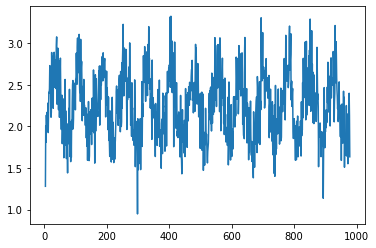

In [264]:
plt.plot(df["fx"].iloc[:chunk_size])

(0.0, 50.0)

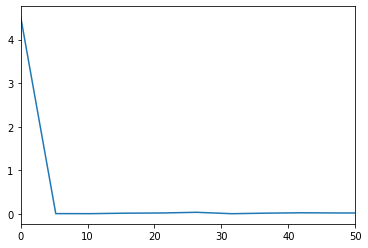

In [265]:
T = dt_mean
N = chunk_size
n = 2
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
yf = fft(df["fx"].iloc[N*n:N*(n+1)].values)

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim((0, 50))

(-50.0, 50.0)

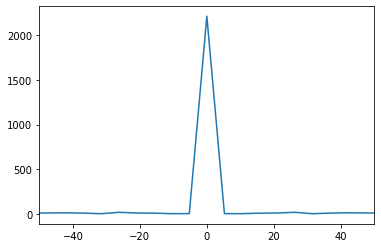

In [266]:
plt.plot(fftshift(fftfreq(N, T)), fftshift(np.abs(yf)))
plt.xlim((-50, 50))

In [267]:
def build_dataset(df, freq=21):
    T = df["dt"].mean()
    N = int(np.ceil(1/freq/dt_mean*4))
    
    data = {}
    data["freqs"] = []
    for n in range(df.shape[0]//N):
        data["freqs"].extend(fftshift(fftfreq(N, T)))
    for col in ["x", "y", "fy", "fx"]:
        data[col + "_f"] = []
        for n in range(df.shape[0]//N):
            data[col + "_f"].extend(fftshift(fft(df[col].iloc[N*n:N*(n+1)].values)))
            
    return data
    
out = build_dataset(df)

In [268]:
out = pd.DataFrame(out)

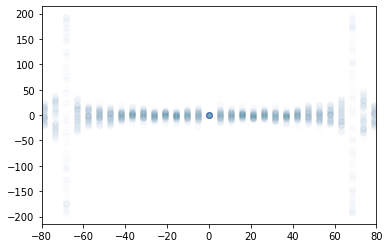

(-80.0, 80.0)

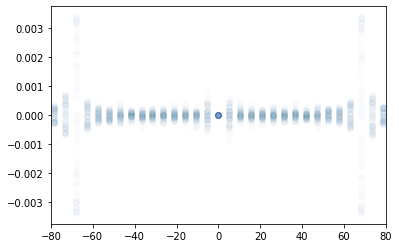

In [269]:
plt.scatter(out["freqs"], np.imag(out["fx_f"]), alpha=0.01)
plt.xlim((-80, 80))
plt.show()
plt.scatter(out["freqs"], np.imag(out["x_f"]), alpha=0.01)
plt.xlim((-80, 80))

In [282]:
out["kyy"] = out.apply(lambda row: np.abs(row["fy_f"])/np.abs(row["y_f"]), axis=1)

In [283]:
out[(np.abs(out["freqs"]) < 80) & (np.abs(out["freqs"]) > 78)]["kyy"].mean()

105336.64472481726

In [284]:
out[(np.abs(out["freqs"]) < 80) & (np.abs(out["freqs"]) > 78)]["fy_f"].mean()/out[(np.abs(out["freqs"]) < 80) & (np.abs(out["freqs"]) > 78)]["y_f"].mean()

(32962.05745948744+0j)

(-50.0, 50.0)

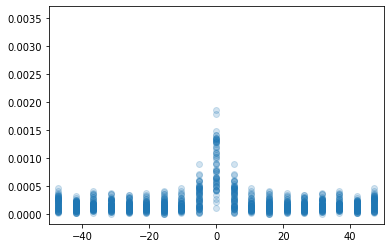

In [285]:
inds = np.abs(out["freqs"]) < 100
plt.scatter(out["freqs"][inds], np.abs(out["x_f"])[inds], alpha=0.2)
plt.xlim((-50, 50))

In [176]:
a = np.abs(out["x_f"])
a = out[np.abs(out["freqs"]) < 24]

In [172]:
a["x_f_abs"] = np.abs(a["x_f"])
a["fy_f_abs"] = np.abs(a["fy_f"])

<ipython-input-172-f675065f3b9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["x_f_abs"] = np.abs(a["x_f"])
<ipython-input-172-f675065f3b9c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["fy_f_abs"] = np.abs(a["fy_f"])


In [174]:
out

,freqs,x_f,y_f,fy_f,fx_f
0,-2560.000117,-1.149999e-06-0.000000e+00j,-0.000004-0.000000j,5.278049-0.000000j,-2.648522-0.000000j
1,-2560.000117,-1.507028e-06+3.338387e-06j,-0.000002+0.000001j,3.666113-0.423126j,-4.490833+2.979984j
2,-2560.000117,6.459039e-07+2.266608e-06j,0.000000-0.000002j,5.471628-0.359658j,1.323785-4.425709j
3,-2560.000117,-6.845224e-07-7.116213e-07j,-0.000003+0.000001j,-3.038492+7.621729j,-2.452428+1.007006j
4,-2560.000117,2.000067e-06+1.018312e-06j,-0.000006+0.000000j,-7.058580-10.875203j,-7.784679-3.110526j
...,...,...,...,...,...
76123,2554.754215,2.921007e-06+1.532331e-06j,0.000007+0.000003j,3.669230-9.733916j,-3.046898+11.249737j
76124,2554.754215,1.936988e-06-4.406308e-07j,0.000007-0.000004j,-3.926662+2.638391j,-2.437787-2.679423j
76125,2554.754215,4.412365e-06-6.297172e-07j,0.000003-0.000004j,11.623112+2.787627j,3.262668+0.589450j
76126,2554.754215,4.842647e-07+1.339904e-06j,0.000002-0.000003j,9.474910-0.462206j,5.142402-5.388260j


In [154]:
np.array(out["x_f"]).shape

(76128,)

In [83]:
df.shape[0]/N

78.68852459016394

In [79]:
yf[:10]

array([2377.99417544  -0.j        ,    4.34678846  -1.34198408j,
         14.77597248  +1.55653978j,   -2.59836866  -3.9193194j ,
        133.96785089-541.07027358j,   17.17450415  +4.51165129j,
          4.5839608   -4.08403718j,   18.78642531 -14.22743688j,
         15.43705431  +3.36073369j,  -11.53154089 +19.13516588j])

In [82]:
yf[:10]

array([ 2.37749727e+03  -0.j        , -5.86463678e+00  -8.9689904j ,
       -4.49018276e+00 +10.17280256j,  7.89001918e+00 -16.4932615j ,
        2.32037823e+02-499.12408744j, -1.45273935e+00  +1.0013218j ,
       -8.44750573e+00  -1.56681667j,  6.80433128e-01  +1.28732651j,
       -8.69700511e+00  +6.42689014j,  6.82132012e+00  +2.13214773j])

In [122]:
from jax import random
from jax.experimental.optimizers import adam, sgd
from jax import numpy as jnp
import jax
%load_ext autoreload
%autoreload 2
from models.frequency_domain import mse, initialize_params, get_batch_forward_pass, get_loss_function, train
from tqdm import tqdm

from utils import Shuffler

rng = random.PRNGKey(20)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
def forward_pass(params, q, f, w, mass=jnp.array([[1, 0],[0, 1]])):
    """
    Um forward pass estima a força no dominio da frequencia

    """
    q = q.reshape((-1, 1))
    M = mass
    C = params[1]
    K = params[0]

    return jnp.squeeze(jax.lax.complex(K - (w**2)*M, w*C) @ q )

In [96]:
params = initialize_params(rng, dims=2)

In [124]:
r = forward_pass(params, yf[:2], yf[:2], w=1)/10000
r

DeviceArray([-0.3958175 -0.34758523j,  0.04963708+0.14944674j], dtype=complex64)

In [128]:
def loss_test(params, x):
    y = forward_pass(params, x, x, w=1)
    return mse(x, y)
jax.grad(loss_test)(params, yf[:2])

[DeviceArray([[-15063043.   ,     68331.3  ],
              [  1194063.4  ,    -16429.734]], dtype=float32),
 DeviceArray([[-8.2638295e+06, -3.6439965e+04],
              [ 3.5744160e+06, -4.3125640e+03]], dtype=float32)]

In [100]:
jnp.abs(r - yf[:2])

DeviceArray([244268.6  ,  15875.392], dtype=float32)

In [121]:
jnp.abs(jnp.conjugate(r)[0]*r[0])

DeviceArray(585.2316, dtype=float32)

In [113]:
jax.lax.complex(2., 1.)*jax.lax.complex(2., -1.)

DeviceArray(5.+0.j, dtype=complex64)